# Задание 1

**Подключение к VK. В Jupyter Notebook нужно отразить подключение и вывод информации о пользователе на экран**

1. Работу ведем в Jupyter Notebook.

2. Изучить API VK https://dev.vk.com/ru/reference

3. Получить токен (ключ доступа) https://dev.vk.com/ru/api/access-token/authcode-flow-
user

4. Попробовать скачать json с информацией о себе (другом пользователе). 
Поля выбрать по своему усмотрению. Список полей https://dev.vk.com/ru/reference/objects/user. Вывести на экран

Токен можно получить здесь: https://vkhost.github.io/

In [1]:
# Устанавливаем необходимые библиотеки

# !pip install vk_requests

In [2]:
import vk_requests    # работа с VK API

## Подключение к VK API

In [3]:
# Здесь необходимо вставить Ваш токен, передавать его никому нельзя!

token = 'vk1.a.b8sv9Dok463Bf1_ANEyBbMiY65FK9TMuKY7MwXAuCLGiacTa4cBysJsOGpeRW19R9vx4pHEl66W0OOMciZW49NDC1jW1hJ_S-Pv0H77LWqKYshwZsA9k2aqETGxVNPRrnIKLG1fd0EPZMdAM5opg3IW2vQE6TcRdowtyQcS4lp62oHKJRtRnh2ml_dNte5KZnHFLDX7_i5jm4MwhxDlEKw'

In [4]:
api = vk_requests.create_api(service_token=token)

## Получение данных по пользователю

In [5]:
# Здесь необходимо вставить Ваш ID профиля

profile_id = 1

In [6]:
api.users.get(user_id=profile_id, fields=[
    'bdate', # День рождения
    'sex', # Пол
    'personal', # Персональная информация, взгляды, языки
    'city', # Родной город
    'religion', # Религия
    'education', # Образование 
    'schools' # Школа
])

[{'id': 1,
  'bdate': '10.10.1984',
  'city': {'id': 2, 'title': 'Санкт-Петербург'},
  'university': 1,
  'university_name': 'СПбГУ',
  'faculty': 0,
  'faculty_name': '',
  'graduation': 2006,
  'personal': {'alcohol': 1,
   'inspired_by': 'Steve Jobs',
   'langs': ['Русский',
    'English',
    'Français',
    'Deutsch',
    'Español',
    'Italiano',
    'Lingua Latina',
    'فارسی'],
   'langs_full': [{'id': 0, 'native_name': 'Русский'},
    {'id': 3, 'native_name': 'English'},
    {'id': 16, 'native_name': 'Français'},
    {'id': 6, 'native_name': 'Deutsch'},
    {'id': 4, 'native_name': 'Español'},
    {'id': 7, 'native_name': 'Italiano'},
    {'id': 666, 'native_name': 'Lingua Latina'},
    {'id': 74, 'native_name': 'فارسی'}],
   'life_main': 6,
   'people_main': 5,
   'political': 9,
   'religion': 'Laissez-faire',
   'smoking': 1},
  'schools': [{'city': 16,
    'class': '',
    'class_id': 0,
    'country': 88,
    'id': '1035386',
    'name': 'Scuola Elementare Coppino - Fal

# Задание 2

**Граф друзей + DataLens + API.Геокодер**

В Jupyter Notebook нужно отразить все шаги + вывод (полученный граф друзей). Ссылку на DataLens разместить в Jupyter Notebook. Не забудьте предоставить доступ к дашборду (полный).
1. Выбрать пользователя (можно не себя).
2. Построить граф друзей (можно использовать другие способы, не тот, что был
показан).
3. Найти кластеры. Предположить, что это за кластеры друзей (работа/учеба/хобби). 
4. Изучить работу с DataLens https://cloud.yandex.ru/docs/datalens/quickstart
5. Изучить работу с API.Геокодер https://yandex.ru/dev/maps/geocoder/#addiwon + код
с занятия
6. Построить карту друзей по городам (количество друзей в каждом городе) в
DataLens.

In [7]:
# Устанавливаем необходимые библиотеки

# !conda install --channel conda-forge pygraphviz

In [8]:
# Выбираем пользователя

user_id = 11

## Получаем список друзей

In [9]:
import requests
import time
import collections
from tqdm import tqdm


def get_friends_ids(api, user_id):
    json_response = api.friends.get(user_id=user_id)
    return json_response

# получаем список друзей друзей выбранного пользователя

graph = {}
friend_ids = get_friends_ids(api, user_id)

print(f'Начинаем поиск друзей и друзей друзей пользователя {user_id}')
for friend_id in tqdm(friend_ids['items'][:100]):
    try:
        graph[friend_id] = get_friends_ids(api, int(friend_id))['items']
    except:
        # случай, если пользователь удален или скрыт
        pass

Начинаем поиск друзей и друзей друзей пользователя 11


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.53it/s]


## Строим граф

100%|████████████████████████████████████████| 10/10 [00:00<00:00, 61320.23it/s]


Graph with 80 nodes and 92 edges


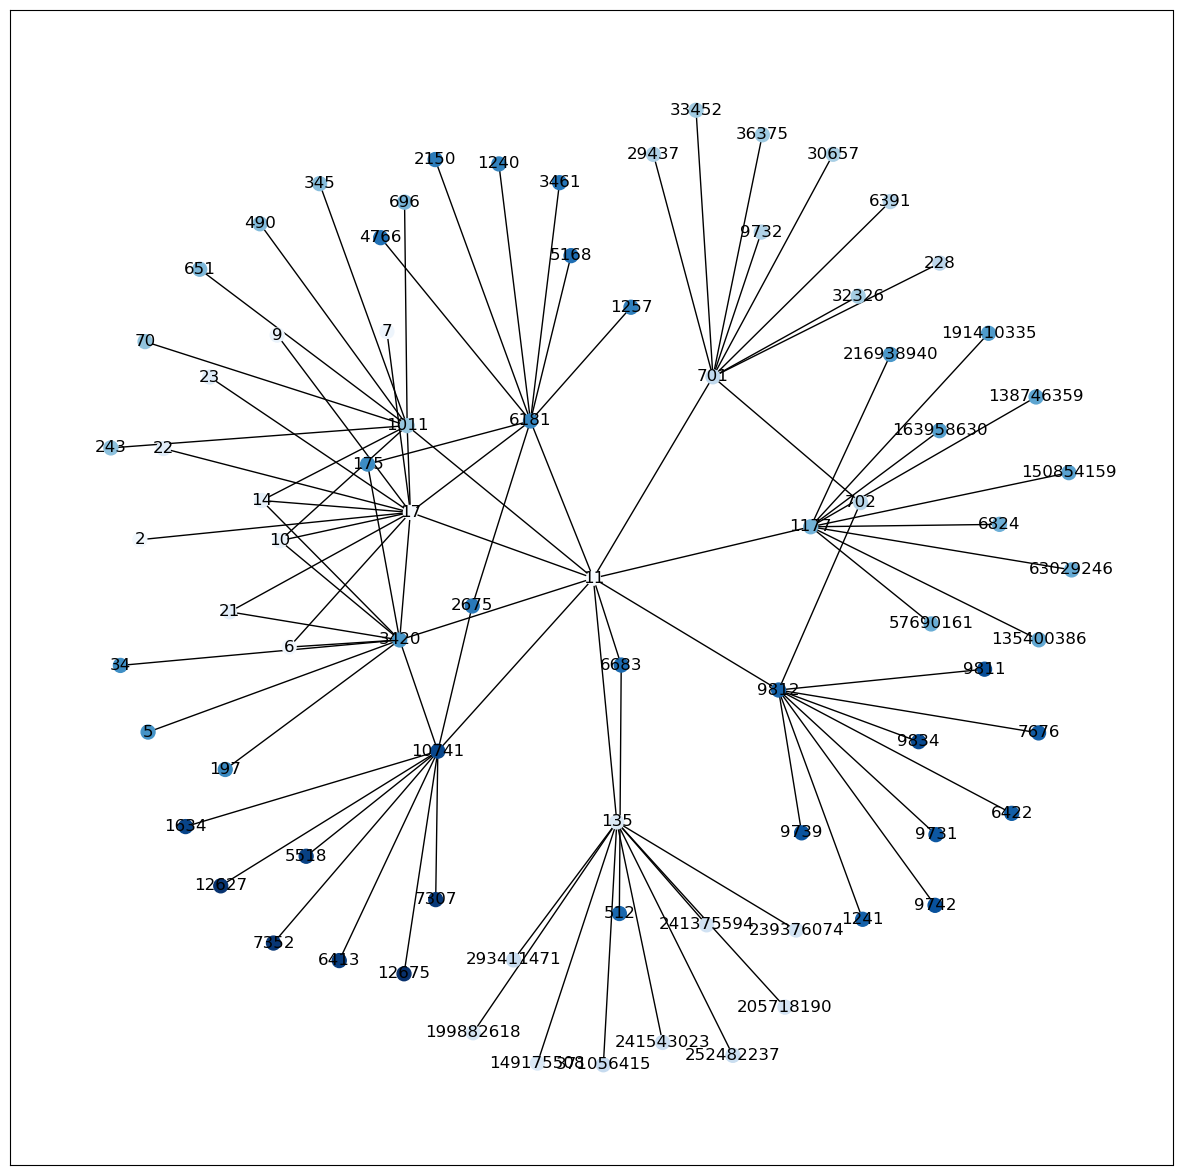

In [10]:
import networkx
import pylab as plt
from tqdm import tqdm
from networkx.drawing.nx_agraph import graphviz_layout

# меняем размер окна, в котором выводится граф
plt.figure(figsize=(15, 15))

g = networkx.Graph(directed=False)

# добавляем центр графа - выбранного пользователя
g.add_node(user_id)

# для пользователя 143 мы бы получили граф с 27722 вершинами и 30467 связями
# из-за этого ограничим каждый уровень вложенности

for parent in tqdm(list(graph.keys())[:10]):
    
    # добавляем друга выбранного пользователя
    g.add_node(parent)
    
    # добавляем связь между выбранными пользователем и его другом
    g.add_edge(user_id, parent)
    
    # итерируемся по всем друзьями друга пользователя
    # добавляем их как ноды
    # и добавляем связи между другом пользователя и его друзьями
    for child in graph[parent][:10]:
        g.add_node(child)
        g.add_edge(parent, child)

print(g)        

# выводим граф с уровнем вложенности 2 
networkx.draw_networkx(g, 
                       pos=graphviz_layout(g), 
                       node_size=100, 
                       cmap=plt.cm.Blues,
                       node_color=range(len(g)))
plt.show()

## Кластеризируем граф алгоритмом Гирван — Ньюмена

In [31]:
import itertools
from networkx.algorithms import community

# Сколько кортежей сообществ будем рассматривать
k = 1
comp = community.girvan_newman(g) 

print('Найденные кластеры')
for communities in itertools.islice(comp, k):
    [print(sorted(c), '\n') for c in communities]

Найденные кластеры
[2, 5, 6, 7, 9, 10, 11, 14, 17, 21, 22, 23, 34, 70, 175, 197, 228, 243, 345, 490, 512, 651, 696, 701, 702, 1011, 1177, 1240, 1241, 1257, 1634, 2150, 2675, 3420, 3461, 4766, 5168, 5518, 6181, 6391, 6413, 6422, 6683, 6824, 7307, 7352, 7676, 9731, 9732, 9739, 9742, 9811, 9812, 9834, 10741, 12627, 12675, 29437, 30657, 32326, 33452, 36375, 57690161, 63029246, 135400386, 138746359, 150854159, 163958630, 191410335, 216938940] 

[135, 149175508, 199882618, 205718190, 239376074, 241375594, 241543023, 252482237, 293411471, 371056415] 



## Построим карту друзей по городам

Можно воспользоваться API GeoCoder, однако доступ к нему с недавнего времени платный
Поэтому воспользуемся этой библиотекой https://pypi.org/project/geopy/1.9.1/

In [12]:
# Устанавливаем необходимые библиотеки

# !pip install geopy

In [71]:
import pandas as pd
import geopy
from geopy.geocoders import Nominatim

# сохраним данные в виде списка, потом переведем его в pandas dataframe
data = []

# создаем объект геолокатора, возвращающего координаты
# если выводит ошибку, поменяйте название агента
geopy.geocoders.options.default_user_agent = "dz1"
geolocator = Nominatim()

# добавляем город выбранного пользователя
user_id_town = api.users.get(user_id=user_id, fields=['city'])[0]['city']['title']
user_id_geolocation = geolocator.geocode(user_id_town)
data.append((user_id, user_id_geolocation.latitude, user_id_geolocation.longitude))

# итерируемся по всем друзьям
for parent in tqdm(list(graph.keys())[:10]):
    
    # итерируемся по всем друзьям пользователя
    try:
        parent_town = api.users.get(user_id=parent, fields=['city'])[0]['city']['title']
        parent_geolocation = geolocator.geocode(parent_town)
        data.append((parent, parent_geolocation.latitude, parent_geolocation.longitude))
    except:
        print(f'У пользователя {parent} не указан город')
    
    # итерируемся по всем друзьями друга пользователя
    for child in graph[parent][:10]:
        try:
            child_town = api.users.get(user_id=child, fields=['city'])[0]['city']['title']
            child_geolocation = geolocator.geocode(child_town)
            data.append((child, child_geolocation.latitude, child_geolocation.longitude))
        except:
            print(f'У пользователя {child} не указан город')

  0%|                                                    | 0/10 [00:00<?, ?it/s]

У пользователя 2 не указан город
У пользователя 10 не указан город


 10%|████▍                                       | 1/10 [00:04<00:40,  4.54s/it]

У пользователя 199882618 не указан город
У пользователя 205718190 не указан город
У пользователя 239376074 не указан город
У пользователя 241375594 не указан город


 20%|████████▊                                   | 2/10 [00:08<00:31,  3.98s/it]

У пользователя 702 не указан город


 30%|█████████████▏                              | 3/10 [00:13<00:31,  4.43s/it]

У пользователя 10 не указан город


 40%|█████████████████▌                          | 4/10 [00:18<00:28,  4.72s/it]

У пользователя 6824 не указан город
У пользователя 163958630 не указан город


 50%|██████████████████████                      | 5/10 [00:23<00:24,  4.88s/it]

У пользователя 10 не указан город


 60%|██████████████████████████▍                 | 6/10 [00:28<00:20,  5.05s/it]

У пользователя 1240 не указан город
У пользователя 2150 не указан город
У пользователя 4766 не указан город


 70%|██████████████████████████████▊             | 7/10 [00:32<00:14,  4.76s/it]

У пользователя 6683 не указан город


 80%|███████████████████████████████████▏        | 8/10 [00:33<00:06,  3.42s/it]

У пользователя 512 не указан город
У пользователя 702 не указан город


100%|███████████████████████████████████████████| 10/10 [00:50<00:00,  5.03s/it]

У пользователя 12675 не указан город


In [72]:
pd_data = pd.DataFrame(data)

KeyError: "None of ['user_id'] are in the columns"

In [73]:
pd_data = pd_data.drop_duplicates()

In [74]:
# Очищенный от дубликатов датасет
pd_data

,0,1,2
0,11,59.938732,30.316229
1,17,59.938732,30.316229
2,6,59.938732,30.316229
3,7,51.507446,-0.127765
4,9,56.010447,37.467083
...,...,...,...
80,5518,55.625578,37.606392
81,6413,59.938732,30.316229
82,7307,47.603832,-122.330062
83,7352,43.653482,-79.383935


In [75]:
pd_data.to_csv('data.csv', header=False)

## Построенная карта в Datalens

https://datalens.yandex/udhj2p10zxnij